In [44]:
import math
import scipy.stats as stats
%pylab inline
import pylab, sys
from scipy.optimize import fsolve
from random import random
import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [45]:
def std_dev(a_list): # Computes the Standard Deviation, taken from Alex Orange
    mean = sum(a_list)/len(a_list)
    return math.sqrt(sum([(_-mean)**2 for _ in a_list])/(len(a_list)-1))

def f2M(x): # converts feet to meters 
    Meter = x/(3.28084)
    return Meter

def m2Km(x): #Convert meters to kilometers 
    km = 0.001*x
    return km

def gps2Dec(degrees, minutes, seconds): # Converts GPS coordinates to Lat and Long in decimal
    D = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    return D

In [46]:
# Uses the Haversine formula to calculate the distance (in meters) between 
# two points given their longitude and latitude in decimal format.
# The Haversine function is defined as: hav(theta) = sin^2(theta/2)
# From: https://en.wikipedia.org/wiki/Haversine_formula
# & https://rosettacode.org/wiki/Haversine_formula#Python
def haverDist(lat1, long1, lat2, long2):
    R      = 6.371009e6 # Earths Radius (m) or 6371.009 (km) or 3958.7613 (miles)
    Long1  = math.radians(long1)
    Lat1   = math.radians(lat1)
    Long2  = math.radians(long2)
    Lat2   = math.radians(lat2)
    dLat   = Lat2 - Lat1
    dLong  = Long2 - Long1 
    eqn1   = math.sin(dLat/2)**2 + math.cos(Lat1)*math.cos(Lat2)*math.sin(dLong/2)**2
    HavDis = R*2*math.atan2(math.sqrt(eqn1), math.sqrt(1-eqn1)) # atan2(y,x) = atan(y/x)
    return HavDis

def haverDist2(transmit1, transmit2):
    lat1, long1, _ = transmit1
    lat2, long2, _ = transmit2
    return haverDist(lat1, long1, lat2, long2)

In [47]:
# Convert Lat, Lon, Altitude to Earth-Centered-Earth-Fixed (ECEF)
# Returns x, y, z in meters. Assumes the elevation to be in feet and then converts it to meters.
# SOURCE: http://danceswithcode.net/engineeringnotes/geodetic_to_ecef/geodetic_to_ecef.html
# TEST ACCURACY: https://www.oc.nps.edu/oc2902w/coord/llhxyz.htm?source=post_page---------------------------
def LatLon2xyz(lat, lon, alt):
    alt   = alt/(3.28084)            # Convert elevation from feet to meters
    lat   = math.radians(lat)                # Convert degrees to radians
    lon   = math.radians(lon)                # Convert degrees to radians
    ec    = 6.6943799901377997e-3   # WGS-84 first eccentricity squared
    a     = 6378137.0               # WGS-84 semi-major axis
    Erad  = 6.371009e6              # Earths radius in meters
    n     = a/math.sqrt(1 - ec*math.sin(lat)*math.sin(lat))
    ecefX = (n + alt)*math.cos(lat)*math.cos(lon)
    ecefY = (n + alt)*math.cos(lat)*math.sin(lon)
    ecefZ = (n*(1 - ec) + alt)*math.sin(lat)
    return ecefX, ecefY, ecefZ

# Use this function to convert x,y,z back to Lat, Lon, Altitude respectively
# Assumes all x,y,z values are in meters and returns Altitude in meters
# SOURCE: http://danceswithcode.net/engineeringnotes/geodetic_to_ecef/geodetic_to_ecef.html
def xyz2LatLon(x, y, z):
    a  = 6378137.0              # WGS-84 semi-major axis
    e2 = 6.6943799901377997e-3  # WGS-84 first eccentricity squared
    a1 = 4.2697672707157535e+4  # a1 = a*e2
    a2 = 1.8230912546075455e+9  # a2 = a1*a1
    a3 = 1.4291722289812413e+2  # a3 = a1*e2/2
    a4 = 4.5577281365188637e+9  # a4 = 2.5*a2
    a5 = 4.2840589930055659e+4  # a5 = a1+a3
    a6 = 9.9330562000986220e-1  # a6 = 1-e2
    w2 = x*x + y*y 
    w  = math.sqrt(w2)
    r2 = w2 + z*z
    r  = math.sqrt(r2)
    Lon = math.atan2(y, x) # Lon 
    s2 = z*z/r2
    c2 = w2/r2
    u = a2/r
    v = a3 - (a4/r)
    if(c2 > 0.3):
        s = (math.sqrt(z**2)/r)*(1.0 + c2*(a1+u+s2*v)/r) # z shouid be positive |z|
        Lat = math.asin(s) # Lat
        ss = s*s
        c = math.sqrt(1.0-ss)
    else:
        c = (w/r)*(1.0 - s2*(a5-u-c2*v)/r)
        Lat = math.acos(c) # Lat
        ss = 1.0 - c*c
        s = math.sqrt(ss)
    rg = a/math.sqrt(1.0 - e2*ss)
    rf = a6*rg
    u = w - rg*c
    v = math.sqrt(z**2) - rf*s # z shouid be positive |z|
    f = c*u + s*v
    m = c*v - s*u
    p = m/((rf/(1.0 - e2*ss))+f) 
    Lat = Lat + p # Lat
    Alt = f + m*p/2.0 # Altitude
    if(z < 0.0):
        Lat *= -1.0 # Lat
    Lat = (180.0/math.pi)*Lat
    Lon = (180.0/math.pi)*Lon
    return Lat, Lon, Alt # Return Lat, Lon, Altitude in that order

In [48]:
# Function that rotates axes 
# Source: https://en.wikipedia.org/wiki/Rotation_(mathematics)#Two_dimensions
def rotXYZ(lat, lon, x, y, z):
    lat = math.radians(lat)
    lon = math.radians(lon)
    xPrime = x*math.cos(-lon) - y*math.sin(-lon) # Rotate on z-axis by -lon
    yPrime = x*math.sin(-lon) + y*math.cos(-lon)
    x = xPrime; y = yPrime # This is the returned x & y
    
    xPrime = x*math.cos(-lat) - z*math.sin(-lat) # Rotate on y-axis by -lat
    zPrime = x*math.sin(-lat) + z*math.cos(-lat)
    x = xPrime; z = zPrime # This is the returned x & z
    
    xPrime = x*math.cos(math.pi/2) - z*math.sin(math.pi/2) # Lastly rotate on y-axis by 90 deg
    zPrime = x*math.sin(math.pi/2) + z*math.cos(math.pi/2)
    x = xPrime; z = zPrime # These are the returned x & z
    return x, y, z

def rotXYZ2(a, b):
    lat, lon = a
    x, y, z = b
    lat = math.radians(lat)
    lon = math.radians(lon)
    xPrime = x*math.cos(-lon) - y*math.sin(-lon) # Rotate on z-axis by -lon
    yPrime = x*math.sin(-lon) + y*math.cos(-lon)
    x = xPrime; y = yPrime # This is the returned x & y
    
    xPrime = x*math.cos(-lat) - z*math.sin(-lat) # Rotate on y-axis by -lat
    zPrime = x*math.sin(-lat) + z*math.cos(-lat)
    x = xPrime; z = zPrime # This is the returned x & z
    
    xPrime = x*math.cos(math.pi/2) - z*math.sin(math.pi/2) # Lastly rotate on y-axis by 90 deg
    zPrime = x*math.sin(math.pi/2) + z*math.cos(math.pi/2)
    x = xPrime; z = zPrime # These are the returned x & z
    return x, y, z

# Uses the distance formula to solve for the distance between the Receiver & Transmitter with  
# the purpose of using these distances to find ratios. Assumes that all inputs are in the 
# x,y,z format and the units are in meters.
def R(xTran, yTran, zTran, xRec, yRec, zRec):
    # Cartesian Distance Formula for 3-Dimensions
    R = math.sqrt((xTran - (xRec))**2 + (yTran - (yRec))**2) # + (zTran - (zRec))**2)
    return R

In [49]:
# Modified function originally written by David DeTienne 801-209-0802, david.detienne@raytheon.
def eqn467(p): # Receivers: Honors Dorm(4), South Medical Tower(6), SMBB(7)
    global gam76, gam64, x4, x6, x7, y4, y6, y7
    x,y = p 
    return (gam76*((x7-x)**2+(y7-y)**2)-(x6-x)**2-(y6-y)**2, # Transmitter z = 0
            gam64*((x6-x)**2+(y6-y)**2)-(x4-x)**2-(y4-y)**2)

def equations(p):
    global gamma01,x0,y0,z0,gamma12,x1,y1,z1,gamma20,x2,y2,z2
    x,y,z = p
    return  (
            gamma01*( (x0-x)**2+(y0-y)**2+(z0)**2 ) - ( (x1-x)**2+(y1-y)**2+(z1)**2 ),
            gamma12*( (x1-x)**2+(y1-y)**2+(z1)**2 ) - ( (x2-x)**2+(y2-y)**2+(z2)**2 ),
            gamma20*( (x2-x)**2+(y2-y)**2+(z2)**2 ) - ( (x0-x)**2+(y0-y)**2+(z0)**2 ),
            )

In [50]:
# Transmit locations in lat, lon & elevation respectively. Elevation is in feet
transmit = { 
    'LegBridge': (40.765037, -111.837156, 4872.0), # 4872 ft in elevation
    'MechBridge': (40.767450, -111.847209, 4747.0), # 4747 ft in elevation
    'PrimaryChildrens': (40.769258, -111.839854, 4834.0), # 4834 ft in elevation
    'PrimaryChildrens2': (40.769177, -111.839733, 4834.0),  # 4834 ft in elevation
    'Beh': (40.761671,-111.846444, 4681.0), 
    'Honors': (40.763942,-111.836838, 4821.0), # 4821 ft in elevation 
    'Browning': (40.766509, -111.847175, 4711.0),
    'MebParkingLot': (40.768976, -111.846548, 4750.0), 
    'McarthyField': (40.766360, -111.839262, 4820.0),
    'McarthyCenter': (40.766401, -111.839234, 4820.0),
} 

#transmit2 = {
#    #'McarthyCenter': (40.766401, -111.839234)
#     k:transmit(v[0],v[1]) for k,v in transmit.items()
#}

# Receive locations in lat, lon & elevation respectively. Elevation is in feet
receivers = { 
    'Honors': (40.7643944, -111.8369806, 4822.0 + 70.0), # Building Height: 70ft
    'BEHS': (40.7615389, -111.8463778, 4681.0 + 154.0), # Building Height: 154ft
    'FriendshipManor': (40.7580028, -111.8531639, 4572.0 + 156.0), # Building Height: 156ft
    'SMBB': (40.7689500, -111.8418944, 4822.0 + 72.0), # Building Height: 72ft
    'SouthMedical': (40.7674472, -111.8313139, 4947.0 + 123.0), # Building Height: 123ft
    'Browning': (40.7662472, -111.8475389, 4711.0 + 98.0), # Building Height: 98ft
    'MEB': (40.7685861, -111.8446944, 4753.0 + 42.0), # Building Height: 42ft
    'Dentistry': (40.7571833, -111.8315111, 4810.0 + 53.0), # Building Height: 53ft
}

# Transmit locations converted from Lat & Lon to x,y,z all units are in meters
transmitXYZ = {  
    k:LatLon2xyz(v[0],v[1],v[2]) for k,v in transmit.items()
}  

# Receive locations converted from Lat & Lon to x,y,z all units are in meters 
receiversXyz = {
    k:LatLon2xyz(v[0],v[1],v[2]) for k,v in receivers.items()   
}

In [51]:
# Fixed receive tower coordinates in meters 
x0, y0, z0 = receiversXyz['BEHS'] 
x1, y1, z1 = receiversXyz['Browning'] 
x2, y2, z2 = receiversXyz['Dentistry']
x3, y3, z3 = receiversXyz['FriendshipManor']  
x4, y4, z4 = receiversXyz['Honors']   
x5, y5, z5 = receiversXyz['MEB'] 
x6, y6, z6 = receiversXyz['SouthMedical'] 
x7, y7, z7 = receiversXyz['SMBB'] 

# Fixed transmit coordinates in meters 
xTran, yTran, zTran = transmitXYZ['McarthyCenter'] # Center of McCarthy Track & Field
xTran2, yTran2, zTran2 = transmitXYZ['PrimaryChildrens']
xTran3, yTran3, zTran3 = transmitXYZ['LegBridge']
xTran4, yTran4, zTran4 = transmitXYZ['MechBridge']
#xTran5, yTran5, zTran5 = transmitXYZ['']

#####################################################
tranLat, tranLon, tranAlt = transmit['McarthyCenter'] # Transmit location in Latitude, Longitude & Altitude
xAve, yAve, zAve = (x4+x6+x7)/3, (y4+y6+y7)/3, (z4+z6+z7)/3 # Average of the 3 receive locations
#xAve, yAve, zAve = (x0+x1+x2+x3+x4+x5+x6+x7)/8, (y0+y1+y2+y3+y4+y5+y6+y7)/8, (z0+z1+z2+z3+z4+z5+z6+z7)/8

In [52]:
print rotXYZ(40.766401, -111.839234, xTran, yTran, zTran)
#print rotXYZ2(transmit2['McarthyCenter'], transmitXYZ['McarthyCenter'])

(21146.341906186582, -2.3283064365386963e-10, 6370496.94815016)


In [53]:
tXrXDist = { # Calculating the distance between the transmitter and each receiver
    'BEHS': R(xTran, yTran, zTran, x0, y0, z0), 
    'Browning': R(xTran, yTran, zTran, x1, y1, z1),
    'Dentistry': R(xTran, yTran, zTran, x2, y2, z2),
    'FriendshipManor': R(xTran, yTran, zTran, x3, y3, z3),
    'Honors': R(xTran, yTran, zTran, x4, y4, z4),
    'MEB': R(xTran, yTran, zTran, x5, y5, z5),
    'SouthMedical': R(xTran, yTran, zTran, x6, y6, z6),
    'SMBB': R(xTran, yTran, zTran, x7, y7, z7),
}

# Calculating the power ratio's using approximate distances between receivers in units of meters
gam76 = (tXrXDist['SouthMedical']**2)/(tXrXDist['SMBB']**2)# Ratio between SMBB and Medical Tower
gam64 = (tXrXDist['Honors']**2)/(tXrXDist['SouthMedical']**2) # Ratio between SMBB and Honors
gam41 = (tXrXDist['Browning']**2)/(tXrXDist['Honors']**2) # Ratio between Honors and Browning
gam17 = (tXrXDist['SMBB']**2)/(tXrXDist['Browning']**2) # Ratio between SMBB and Browning
print 'gam76:', gam76
print 'gam64:', gam64

gam76: 5.69354975345
gam64: 0.1396254004


In [54]:
print 'Tx MechBridge to x,y,z:', transmitXYZ['MechBridge']
print 'Tx McarthyCenter to x,y,z:', transmitXYZ['McarthyCenter']
# Can compare this distance with Google maps
print 'Dist between Mac Field and Honors:', haverDist2(xyz2LatLon(x4, y4, z4), (tranLat, tranLon, 0.0))

Tx MechBridge to x,y,z: (-1800597.74447466, -4491080.158767237, 4143843.2505026623)
Tx McarthyCenter to x,y,z: (-1800007.1860178306, -4491417.006443407, 4143769.532524898)
Dist between Mac Field and Honors: 292.91566546


(-1800007.1860178306, -4491417.006443407, -1800007.1860177307, -4491417.006443346, -1799807.9052980768, -4491488.2999112485, (9.554299322189763e-05, -1.7493526684120297e-05), 0.1396254003995667, 5.693549753454587)
Calculated Tx (x,y): -1800007.1860177307 -4491417.006443346
Actual Tx (x,y): -1800007.18602 -4491417.00644
Computed Transmit Location (Lat, Lon): (40.76640100000056, -111.83923399999918, 1469.1359529174076)
Actual Transmit Location (Lat, Lon):   40.766401 -111.839234
---------- Error ----------
Computed error in meters: 9.26087304972e-08
Actual error in meters: 7.07324088189e-10


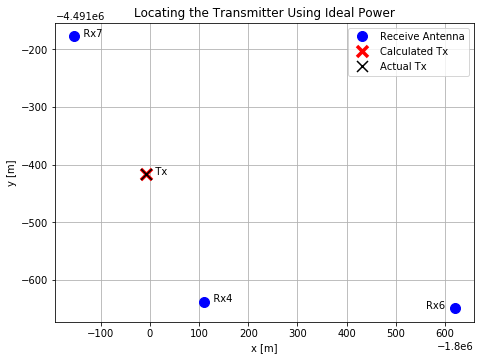

In [55]:
### Locating the Transmitter Using Ideal Power

x,y = fsolve(eqn467, (xAve, yAve)) # These are the Actual x,y
print(xTran, yTran, x, y, xAve, yAve, eqn467((x, y)), gam64, gam76)
print 'Calculated Tx (x,y):', x, y
print 'Actual Tx (x,y):', xTran, yTran
print 'Computed Transmit Location (Lat, Lon):', xyz2LatLon(x, y, zTran) # Computed Tx site
print 'Actual Transmit Location (Lat, Lon):  ', tranLat, tranLon      # Actual Tx site
print '---------- Error ----------'
print 'Computed error in meters:', haverDist2(xyz2LatLon(x, y, zTran), (tranLat, tranLon, 0.0)) # Transmit z = 0.0
print 'Actual error in meters:', haverDist2(xyz2LatLon(xTran, yTran, zTran), (tranLat, tranLon, 0.0))

pylab.figure(figsize=(7.5,5.5)) 
pylab.plot([x4,x6,x7], [y4,y6,y7], 'bo', markersize=10.0, label='Receive Antenna')
plt.text(x4,y4,'   Rx4'); plt.text(x6,y6,'Rx6   ',horizontalalignment='right'); plt.text(x7,y7,'   Rx7')
plt.text(x,y,'   Tx')
pylab.plot([x], [y], 'rx',mew=3.5, markersize=11.0, label='Calculated Tx')
pylab.plot([xTran], [yTran], 'kx',mew=1.5, markersize=11.0, label='Actual Tx')
pylab.xlabel('x [m]')
pylab.ylabel('y [m]')
pylab.title('Locating the Transmitter Using Ideal Power')
pylab.legend()
pylab.grid()
plt.savefig('PowerGeo.svg', bbox_inches='tight')

p4 Err: -0.609446143851 | p6 Err: 0.780118946064 | p7 Err: -1.33802308796
x = -1799907.7770879124 y = -4491378.699840103
The average x,y of the 3 Receivers: -1799807.9053 , -4491488.29991
Standard Deviation: 1.4942531772
Difference between the std_dev and the average for x,y: -1799939.4280437997 -4491368.91217093
Difference between Esimated & Actual Tx site in meters (x,y): 99.40892991819419 , 38.30660330411047
Total Error [m]: 91.1183544739


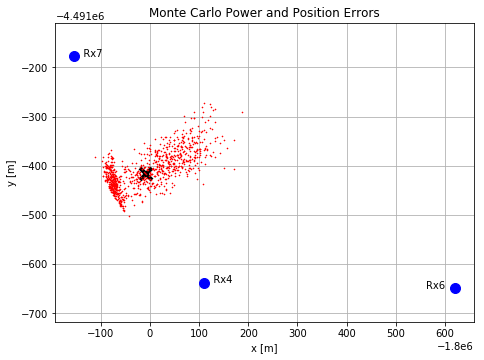

In [56]:
### Monte Carlo Power and Position Errors

pylab.figure(figsize=(7.5,5.5))
pylab.plot([x4,x6,x7],[y4,y6,y7],'bo',markersize=10.0, label='Receive Antenna')
plt.text(x4,y4,'   Rx4'); plt.text(x6,y6,'Rx6   ',horizontalalignment='right'); plt.text(x7,y7,'   Rx7')
pylab.title('Monte Carlo Power and Position Errors')
pylab.xlabel('x [m]')
pylab.ylabel('y [m]')
pylab.grid()
pylab.axis('equal') 

xList=[]; yList=[]; p4N=[]; p6N=[]; p7N=[]
p4 = 10.0*math.log10(1/(tXrXDist['Honors']**2)) 
p6 = 10.0*math.log10(1/(tXrXDist['SouthMedical']**2))
p7 = 10.0*math.log10(1/(tXrXDist['SMBB']**2))
stdev = 1.0 # Standard Deviation
for k in range(0,900):  
    
    ## Receive power converted to dB and added Random Gaussian
    ## error with standard deviation 
    p4_err = p4 + np.random.normal(0.0, stdev)
    p4N.append(p4_err)
    p6_err = p6 + np.random.normal(0.0, stdev)
    p6N.append(p6_err)
    p7_err = p7 + np.random.normal(0.0, stdev) 
    p7N.append(p7_err)

    ## New converted Power with error
    p4New = (10.0)**(p4_err/10.0) 
    p6New = (10.0)**(p6_err/10.0)
    p7New = (10.0)**(p7_err/10.0)
   
    ## New Ratios 
    gam64 = p6New/p4New 
    gam76 = p7New/p6New
    
    #xAve = (x4+x6+x7)/3; yAve = (y4+y6+y7)/3
    xMonte, yMonte = fsolve(eqn467, (xAve, yAve)) # Plot Transmit Location
    xList.append(xMonte); yList.append(yMonte)
    
print 'p4 Err:', p4N[k] - p4, '|', 'p6 Err:', p6N[k] - p6, '|', 'p7 Err:', p7N[k] - p7 
print 'x =',xList[k], 'y =',yList[k]
print 'The average x,y of the 3 Receivers:', xAve, ',' ,yAve

pylab.plot([x], [y], 'kx', mew=4.0, markersize=12.5) # Plot black 'X', the actual Tx site
pylab.plot(xList, yList,'rx',markersize=1.0,label='Transmitter') # Plot the red dots (Error)
plt.savefig('PowerMonteCarlo.svg',  bbox_inches='tight')
#------------------------------------------------------------------------------------------------------------------

a = [np.random.normal(0, 1.5) for _ in range(1000)]
print 'Standard Deviation:', std_dev(a)

# print 'Comparing Power Numbers ', p4, (1/(tXrXDist['Honors']**2)), 10**(p4/10.0)
stdDevX = std_dev(xList); stdDevY = std_dev(yList) # Standard Deviation for x & y Lists
x_Average = (sum(xList)/len(xList)); y_Average = (sum(yList)/len(yList)) # x,y Averages
print 'Difference between the std_dev and the average for x,y:', stdDevX + x_Average, stdDevY + y_Average

xDiff = xMonte - xTran; yDiff = yMonte - yTran
print 'Difference between Esimated & Actual Tx site in meters (x,y):', xDiff, ',', yDiff
print 'Total Error [m]:', haverDist2(xyz2LatLon(xMonte, yMonte, zTran), (tranLat, tranLon, 0.0)) # Transmit z = 0.0

Standard Deviation: 1.509380495


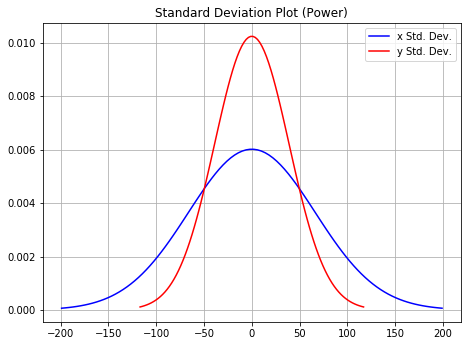

Averages (xList, yList): -1800005.7815417547 , -4491407.886006549
Standard Deviations (xList, yList): 66.3534979549 , 38.973835619


In [57]:
def std_dev(a_list): # Computes the Standard Deviation, taken from Alex Orange
    mean = sum(a_list)/len(a_list)
    return math.sqrt(sum([(_-mean)**2 for _ in a_list])/(len(a_list)-1))

def var(a_list):
    mean = sum(a_list)/len(a_list)
    return(math.sqrt(sum([(_-mean)**2 for _ in a_list])/(len(a_list)-1))**2)

a = [np.random.normal(0, 1.5) for _ in range(1000)]
print 'Standard Deviation:', std_dev(a)

x_mu = 0 #sum(xList)/len(xList)
x_var = var(xList)
x_sigma = std_dev(xList)
x_sigma_weight = 3
xPart = np.linspace(x_mu - x_sigma_weight*x_sigma, x_mu + x_sigma_weight*x_sigma, 100)

y_mu = 0 #sum(yList)/len(yList)
y_var = var(yList)
y_sigma = std_dev(yList)
y_sigma_weight = 3
yPart = np.linspace(y_mu - y_sigma_weight*y_sigma, y_mu + y_sigma_weight*y_sigma, 100)

plt.figure(figsize=(7.5,5.5))
plt.title('Standard Deviation Plot (Power)')
plt.plot(xPart, stats.norm.pdf(xPart, x_mu, x_sigma),'b-', label='x Std. Dev.')
plt.plot(yPart, stats.norm.pdf(yPart, y_mu, y_sigma),'r-', label='y Std. Dev.')
plt.grid(); plt.legend(); plt.show()

# print 'Comparing Power Numbers ', p4, (1/(tXrXDist['Honors']**2)), 10**(p4/10.0)
print 'Averages (xList, yList):', (sum(xList)/len(xList)), ',', (sum(yList)/len(yList))
print 'Standard Deviations (xList, yList):', std_dev(xList), ',', std_dev(yList)

In [58]:
### Geolocation Through TDOA 

# Time Difference of Arrival  does not require the time that the signal was sent from the 
# target, only the time the signal was received and the speed that the signal travels.
# Once the signal is received at two reference points, the difference in arrival time can be
# used to calculate the difference in distances between the target and the two reference points.
# https://onlinelibrary.wiley.com/doi/full/10.4218/etrij.17.0116.0554

# Solve for the transmit location using TDOA 
def tdoa467(p): # Receivers: Honors Dorm(4), South Medical Tower(6), SMBB(7)
    global t67,t74,x4,x6,x7,y4,y6,y7,c
    #x,y = p 
    x,y = p
    d4 = math.sqrt((x4 - x)**2 + (y4 - y)**2) 
    d6 = math.sqrt((x6 - x)**2 + (y6 - y)**2) 
    d7 = math.sqrt((x7 - x)**2 + (y7 - y)**2)
    
    return(t67 - ((d6/c) - d7/c), 
           t74 - ((d7/c) - d4/c))

-1799890.8573 -1799379.55518 -1800153.30341
-4491638.31667 -4491648.91513 -4491177.66794
4143615.05256 4143907.30212 4143998.6939
Calculated Tx (x,y): -1799625.6403365459 -4491182.1279230295
Actual Tx (x,y): -1800007.18602 -4491417.00644
Average Tx (x,y): -1799807.9053 -4491488.29991
Substituting the Calculated x,y back into the function: (5.935744547078548e-14, -2.5059924177694677e-14)
Calculated Transmit Location (Lat, Lon): (40.76851713099601, -111.8360746884899, 1196.521602676061)
Actual Transmit Location (Lat, Lon): 40.766401 -111.839234
------====---- Error ----------
Calculated error in meters: 355.185853899
Actual error in meters: 7.07324088189e-10


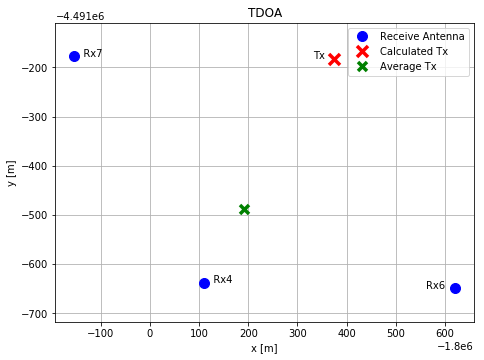

In [59]:
c = 299792458.0 # Speed of light [m/sec]
#t67 = dist67/c; t74 = dist74/c
t67=0.0; t74=0.0
# xTran,yTran     xAve,yAve
print x4, x6, x7
print y4, y6, y7
print z4, z6, z7

x, y = fsolve(tdoa467, (xAve, yAve)) # These are the Actual x,y of the transmitter in meters
print 'Calculated Tx (x,y):', x, y
print 'Actual Tx (x,y):', xTran, yTran
print 'Average Tx (x,y):', xAve, yAve

print 'Substituting the Calculated x,y back into the function:', tdoa467((x, y)) 
print 'Calculated Transmit Location (Lat, Lon):', xyz2LatLon(x, y, zTran) # Computed Tx site
print 'Actual Transmit Location (Lat, Lon):', tranLat, tranLon            # Actual Tx site
print '------====---- Error ----------'
print 'Calculated error in meters:', haverDist2(xyz2LatLon(x, y, zTran), (tranLat, tranLon, 0.0)) # Tx z = 0.0
print 'Actual error in meters:', haverDist2(xyz2LatLon(xTran, yTran, zTran), (tranLat, tranLon, 0.0)) # Tx z = 0.0

pylab.figure(figsize=(7.5,5.5))
pylab.plot([x4,x6,x7], [y4,y6,y7], 'bo',markersize=10.0, label='Receive Antenna')
plt.text(x4,y4,'   Rx4'); plt.text(x6,y6,'Rx6   ',horizontalalignment='right'); plt.text(x7,y7,'   Rx7')
plt.text(x,y,'Tx   ' ,horizontalalignment='right')
pylab.plot([x], [y], 'rx',mew=3.5, markersize=11.0, label='Calculated Tx')
pylab.plot([xAve], [yAve], 'gx',mew=3.5, markersize=9.0, label='Average Tx')
#pylab.plot([xTran], [yTran], 'kx',mew=1.5, markersize=11.0, label='Actual Tx')
pylab.title('TDOA')
pylab.xlabel('x [m]')
pylab.ylabel('y [m]')
pylab.grid()
pylab.legend()
pylab.axis('equal')
plt.savefig('TdoaGeo.svg', bbox_inches='tight')

In [60]:
#transmit = { 
#    'LegBridge': (40.765037, -111.837156, 4872.0), # 4872 ft in elevation
#    'MechBridge': (40.767450, -111.847209, 4747.0), # 4747 ft in elevation
#    'PrimaryChildrens': (40.769258, -111.839854, 4834.0), # 4834 ft in elevation
#    'PrimaryChildrens2': (40.769177, -111.839733, 4834.0),  # 4834 ft in elevation
#    'Beh': (40.761671,-111.846444, 4681.0), 
#    'Honors': (40.763942,-111.836838, 4821.0), # 4821 ft in elevation 
#    'Browning': (40.766509, -111.847175, 4711.0),
#    'MebParkingLot': (40.768976, -111.846548, 4750.0), 
#    'McarthyField': (40.766360, -111.839262, 4820.0),
#    'McarthyCenter': (40.766401, -111.839234, 4820.0),
#} 
#list(transmit.items())[4][0]
SQ = transmitXYZ.items()[-4][1][2]
print SQ

4144005.84746


tdoa67: 1.29652798158e-06 --- tdoa74: 1.01386707929e-07
 
Calculated Tx (x,y): -1800007.1858904136 -4491417.006311179
Actual Tx (x,y): -1800007.18602 -4491417.00644
 
Calculated error in meters: 0.000130825723261
Actual error in meters: 7.07324088189e-10


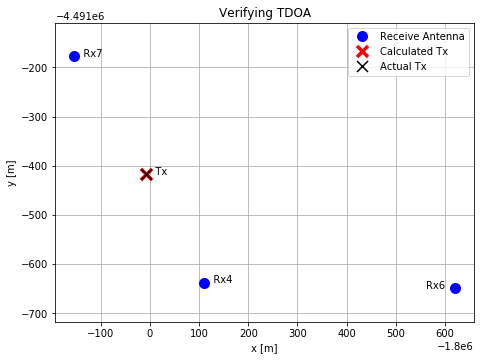

In [61]:
xMac, yMac, zMac = transmitXYZ['McarthyCenter'] # Center of McCarthy Track & Field

def d(xMac, yMac, xRec, yRec): # Cartesian Distance Formula for 2-Dimensions
    dist = math.sqrt(((xRec) - xMac)**2 + ((yRec) - yMac)**2)
    return dist
            
dist = {
    'BEHS': d(xMac, yMac, x0, y0),            # 0
    'Browning': d(xMac, yMac, x1, y1),        # 1
    'Dentistry': d(xMac, yMac, x2, y2),       # 2
    'FriendshipManor': d(xMac, yMac, x3, y3), # 3
    'Honors': d(xMac, yMac, x4, y4),          # 4
    'MEB': d(xMac, yMac, x5, y5),             # 5 
    'SouthMedical': d(xMac, yMac, x6, y6),    # 6
    'SMBB': d(xMac, yMac, x7, y7),            # 7
}

t67 = (dist['SouthMedical']/c) - (dist['SMBB']/c)
t74 = (dist['SMBB']/c) - (dist['Honors']/c)
print 'tdoa67:', t67, '--- tdoa74:', t74
print ' '
x, y = fsolve(tdoa467, (xAve, yAve)) # These are the Actual x,y of the transmitter in meters
print 'Calculated Tx (x,y):', x, y
print 'Actual Tx (x,y):', xTran, yTran
print ' '
print 'Calculated error in meters:', haverDist2(xyz2LatLon(x, y, zTran), (tranLat, tranLon, 0.0)) # Tx z = 0.0
print 'Actual error in meters:', haverDist2(xyz2LatLon(xTran, yTran, zTran), (tranLat, tranLon, 0.0)) # Tx z = 0.0

pylab.figure(figsize=(7.5,5.5))
pylab.plot([x4,x6,x7], [y4,y6,y7], 'bo',markersize=10.0, label='Receive Antenna')
plt.text(x4,y4,'   Rx4'); plt.text(x6,y6,'Rx6   ',horizontalalignment='right'); plt.text(x7,y7,'   Rx7')
plt.text(x,y,'   Tx')
pylab.plot([x], [y], 'rx',mew=3.5, markersize=11.0, label='Calculated Tx')
pylab.plot([xTran], [yTran], 'kx',mew=1.5, markersize=11.0, label='Actual Tx')
#pylab.plot([xTran], [yTran], 'kx',mew=1.5, markersize=11.0, label='Actual Tx')
pylab.title('Verifying TDOA')
pylab.xlabel('x [m]')
pylab.ylabel('y [m]')
pylab.grid()
pylab.legend()
pylab.axis('equal')
plt.savefig('TdoaGeo.svg', bbox_inches='tight')

| t67_Err: 4.18533940547e-08 | t74_Err: 1.43350093436e-07 |
x = -1800031.406736716 y = -4491455.835463998
The average x,y of the 3 Receivers: -1799807.9053 , -4491488.29991
Standard Deviation: 1.4635525293
Difference between the std_dev and the average for x,y: -1799975.0739331096 -4491389.8582283575
Difference between Esimated & Actual Tx site in meters (x,y): 24.2207188853 , 38.8290205905
Total Error [m]: 30.5212051168


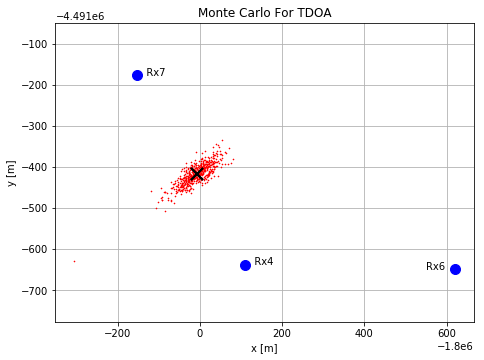

In [62]:
# The main goal of Monte Carlo is to use repeated random sampling 
# to obtain numerical results. The most straightforward algorithm 
# for Monte Carlo can basically be broken down into the following steps:

#    1) Get some random input
#    2) Evaluate
#    3) Repeat steps 1 and 2 as needed (To improve accuracy, more is better)
#    4) Determine the average of all these samples and multiply by the range

pylab.figure(figsize=(7.5,5.5))
pylab.plot([x4,x6,x7],[y4,y6,y7],'bo',markersize=10.0, label='Receive Antenna')
plt.text(x4,y4,'   Rx4');  plt.text(x6,y6,'Rx6   ',horizontalalignment='right'); plt.text(x7,y7,'   Rx7')
pylab.title('Monte Carlo For TDOA')
pylab.xlabel('x [m]')
pylab.ylabel('y [m]')
pylab.grid()
pylab.axis('equal') 

xList=[]; yList=[]; r4N=[]; r6N=[]; r7N=[]; tdoa67=[]; tdoa74=[]
t_67 = (dist['SouthMedical']/c) - (dist['SMBB']/c)
t_74 = (dist['SMBB']/c) - (dist['Honors']/c)
R4 = dist['Honors']
R6 = dist['SouthMedical']
R7 = dist['SMBB']

stdev = 20.0 # Standard Deviation
n = 500
for k in range(0,n):  
    
    ## TDOA's with random Gaussian error & standard deviation 
    
    r4_err = R4 + np.random.normal(0.0, stdev)
    r4N.append(r4_err)
    r6_err = R6 + np.random.normal(0.0, stdev)
    r6N.append(r6_err)
    r7_err = R7 + np.random.normal(0.0, stdev)
    r7N.append(r7_err)
    
    t67 = (r6_err/c) - (r7_err/c)
    tdoa67.append(t67)
    t74 = (r7_err/c) - (r4_err/c)
    tdoa74.append(t74)
    
    xMonte, yMonte = fsolve(tdoa467, (xAve, yAve)) # Plot Transmit Location
    xList.append(xMonte); yList.append(yMonte)
    
    t67_Err = math.sqrt((tdoa67[k] - t_67)**2)
    t74_Err = math.sqrt((tdoa74[k] - t_74)**2)
print '|', 't67_Err:', t67_Err, '|', 't74_Err:', t74_Err, '|'
print 'x =',xList[k], 'y =',yList[k] # 'x =',xList[k], 'y =',yList[k]
print 'The average x,y of the 3 Receivers:', xAve, ',' ,yAve

pylab.plot(xList, yList,'rx',markersize=1.0,label='Transmitter') # Plot the red dots (Error)
pylab.plot([x], [y], 'kx', mew=2.0, markersize=12.5) # Plot black 'X', the actual Tx site
plt.savefig('Tdoa_Monte_Carlo.svg',  bbox_inches='tight')
pylab.plot([x], [y], 'kx', mew=2.0, markersize=12.5) # Plot black 'X', the actual Tx site
#------------------------------------------------------------------------------------------------------------------

a = [np.random.normal(0, 1.5) for _ in range(1000)]
print 'Standard Deviation:', std_dev(a)

# print 'Comparing Power Numbers ', p4, (1/(tXrXDist['Honors']**2)), 10**(p4/10.0)
stdDevX = std_dev(xList); stdDevY = std_dev(yList) # Standard Deviation for x & y Lists
x_Average = (sum(xList)/len(xList)); y_Average = (sum(yList)/len(yList)) # x,y Averages
print 'Difference between the std_dev and the average for x,y:', stdDevX + x_Average, stdDevY + y_Average

xDiff = xMonte - xTran; yDiff = yMonte - yTran
print 'Difference between Esimated & Actual Tx site in meters (x,y):', math.sqrt(xDiff**2), ',', math.sqrt(yDiff**2)
print 'Total Error [m]:', haverDist2(xyz2LatLon(xMonte, yMonte, zTran), (tranLat, tranLon, 0.0)) # Transmit z = 0.0

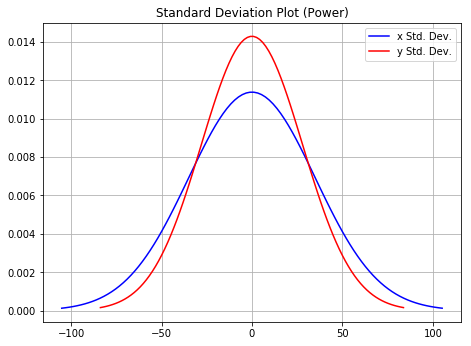

Averages (xList, yList): -1800010.13291898 , -4491417.782976507
Standard Deviations (xList, yList): 35.0589858704 , 27.92474815


In [63]:
x_mu = 0 #sum(xList)/len(xList)
x_var = var(xList)
x_sigma = std_dev(xList)
x_sigma_weight = 3
xPart = np.linspace(x_mu - x_sigma_weight*x_sigma, x_mu + x_sigma_weight*x_sigma, 100)

y_mu = 0 #sum(yList)/len(yList)
y_var = var(yList)
y_sigma = std_dev(yList)
y_sigma_weight = 3
yPart = np.linspace(y_mu - y_sigma_weight*y_sigma, y_mu + y_sigma_weight*y_sigma, 100)

plt.figure(figsize=(7.5,5.5))
plt.title('Standard Deviation Plot (TDOA)')
plt.plot(xPart, stats.norm.pdf(xPart, x_mu, x_sigma),'b-', label='x Std. Dev.')
plt.plot(yPart, stats.norm.pdf(yPart, y_mu, y_sigma),'r-', label='y Std. Dev.')
plt.grid(); plt.legend(); plt.show()

# print 'Comparing Power Numbers ', p4, (1/(tXrXDist['Honors']**2)), 10**(p4/10.0)
print 'Averages (xList, yList):', (sum(xList)/len(xList)), ',', (sum(yList)/len(yList))
print 'Standard Deviations (xList, yList):', std_dev(xList), ',', std_dev(yList)

| t67_Err: 19.1917175038 | t74_Err: 3.20204025741 |
x = 223957353.06661373 y = -125756389.32134362
The average x,y of the 3 Receivers: -1799807.9053 , -4491488.29991
Standard Deviation: 1.52493367747
Difference between the std_dev and the average for x,y: 6060265400.67949 6866918398.500918
Difference between Esimated & Actual Tx site in meters (x,y): 225757360.253 , 121264972.315
Total Error [m]: 9311332.2265


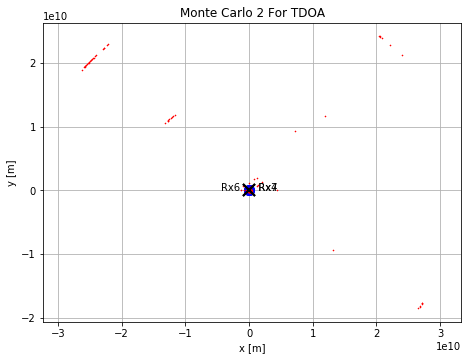

In [64]:
pylab.figure(figsize=(7.5,5.5))
pylab.plot([x4,x6,x7],[y4,y6,y7],'bo',markersize=10.0, label='Receive Antenna')
plt.text(x4,y4,'   Rx4');  plt.text(x6,y6,'Rx6   ',horizontalalignment='right'); plt.text(x7,y7,'   Rx7')
pylab.title('Monte Carlo 2 For TDOA')
pylab.xlabel('x [m]')
pylab.ylabel('y [m]')
pylab.grid()
pylab.axis('equal') 

xList=[]; yList=[]; tdoa67=[]; tdoa74=[]
stdev = 20 # Standard Deviation
n = 500
for k in range(0,n):  
    ## TDOA's with random Gaussian error & standard deviation 
    tdoa_67 = (dist['SouthMedical']/c) - (dist['SMBB']/c)
    tdoa_74 = (dist['SMBB']/c) - (dist['Honors']/c)
    
    t67 = tdoa_67 + np.random.normal(0.0, stdev)
    tdoa67.append(t67)
    t74 = tdoa_74 + np.random.normal(0.0, stdev)
    tdoa74.append(t74)
    
    xMonte, yMonte = fsolve(tdoa467, (xAve, yAve)) # Plot Transmit Location
    xList.append(xMonte); yList.append(yMonte)
    
    t67_Err = math.sqrt((tdoa67[k] - t_67)**2)
    t74_Err = math.sqrt((tdoa74[k] - t_74)**2)
print '|', 't67_Err:', t67_Err, '|', 't74_Err:', t74_Err, '|'
print 'x =',xList[k], 'y =',yList[k] # 'x =',xList[k], 'y =',yList[k]
print 'The average x,y of the 3 Receivers:', xAve, ',' ,yAve

pylab.plot(xList, yList,'rx',markersize=1.0,label='Transmitter') # Plot the red dots (Error)
pylab.plot([x], [y], 'kx', mew=2.0, markersize=12.5) # Plot black 'X', the actual Tx site
plt.savefig('Tdoa_Monte_Carlo.svg',  bbox_inches='tight')
pylab.plot([x], [y], 'kx', mew=2.0, markersize=12.5) # Plot black 'X', the actual Tx site
#------------------------------------------------------------------------------------------------------------------

a = [np.random.normal(0, 1.5) for _ in range(1000)]
print 'Standard Deviation:', std_dev(a)

# print 'Comparing Power Numbers ', p4, (1/(tXrXDist['Honors']**2)), 10**(p4/10.0)
stdDevX = std_dev(xList); stdDevY = std_dev(yList) # Standard Deviation for x & y Lists
x_Average = (sum(xList)/len(xList)); y_Average = (sum(yList)/len(yList)) # x,y Averages
print 'Difference between the std_dev and the average for x,y:', stdDevX + x_Average, stdDevY + y_Average

xDiff = xMonte - xTran; yDiff = yMonte - yTran
print 'Difference between Esimated & Actual Tx site in meters (x,y):', math.sqrt(xDiff**2), ',', math.sqrt(yDiff**2)
print 'Total Error [m]:', haverDist2(xyz2LatLon(xMonte, yMonte, zTran), (tranLat, tranLon, 0.0)) # Transmit z = 0.0

In [65]:
# Useful link: https://www.rapidtables.com/electric/dBm.html

Pt = 10.0 #(10.0)**(-10.0/10.0) # Power transmitted [dB]
Gt = -35.5 # B210 Radio transmit gain [dB]
Gr = -89.0 # X310 Radio receive gain [dB]
c = 299792458.0 # Speed of light [m/s]
freq = 5.565e+9 # Frequency [Hz]
lamda = c/freq
d4 = dist['Honors'] # Distance from Honors Dorm to Transmitter
d6 = dist['SouthMedical'] # Distance from South Medical to Transmitter
d7 = dist['SMBB'] # Distance from SMBB to Transmitter

pR4 = Pt*Gt*Gr*((lamda/(4*math.pi*d4))**2)
pR6 = Pt*Gt*Gr*((lamda/(4*math.pi*d6))**2)
pR7 = Pt*Gt*Gr*((lamda/(4*math.pi*d7))**2)

# Calculating the power ratio's using approximate distances between receivers in units of meters
gam76 = (pR6**2)/(pR7**2) # Ratio between SMBB and Medical Tower
gam64 = (pR4**2)/(pR6**2) # Ratio between SMBB and Honors

print pR4
print pR6
print pR7
print '----------'
print gam76
print gam64



9.28872557605e-06
1.29694202776e-06
7.38420396238e-06
----------
0.0308484792833
51.294539696
